# modelo Toxicidade ToxCast baseado em SMILES com células LSTM no PyTorch

In [ ]:
!pip install torch

In [ ]:
!pip install rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 43.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import rdkit
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
print('Pytorch Versao',torch.__version__)
print('RDkit Versao',rdkit.__version__)


Pytorch Versao 2.5.1+cpu
RDkit Versao 2024.09.5


Carregar o arquivo CSV :

In [ ]:
import os
os.chdir("/content/")

# fazer o upload do arq TXT na pasta 'content' do Colab antes de tudo

In [ ]:
# Load your dataset with molecular data and target chemical properties
# Here, we assume you have a CSV file with 'SMILES' (molecular structure) and 'ToxCast' columns

data = pd.read_csv('ToxCast_final4.csv', sep=';', encoding='latin1')
data.head()

,SMILES,ToxCast
0,OCCOC(=O)C1=CC=CC=C1O,3
1,C\C=C1\C(=O)C[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C...,31
2,CC(CC1=CC=CC=C1)NCCCCl,0
3,Cl.COC1=CC2=NC(=NC(N)=C2C=C1OC)N1CCN(CC1)C(=O)...,3
4,ClC1CC2C(C1Cl)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl,35


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole  #faz aparecer o desenho

PandasTools.AddMoleculeColumnToFrame(data,'SMILES','Molecule')
data[["SMILES","Molecule"]].head()

[03:43:28] WARNING: not removing hydrogen atom without neighbors
[03:43:28] WARNING: not removing hydrogen atom without neighbors


,SMILES,Molecule
0,OCCOC(=O)C1=CC=CC=C1O,<rdkit.Chem.rdchem.Mol object at 0x7d25e75cfdf0>
1,C\C=C1\C(=O)C[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C...,<rdkit.Chem.rdchem.Mol object at 0x7d25e7d5f0d0>
2,CC(CC1=CC=CC=C1)NCCCCl,<rdkit.Chem.rdchem.Mol object at 0x7d25e7d5e180>
3,Cl.COC1=CC2=NC(=NC(N)=C2C=C1OC)N1CCN(CC1)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7d25e7d5c660>
4,ClC1CC2C(C1Cl)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7d25e7d5d0e0>


In [ ]:
data.head()

,SMILES,ToxCast,Molecule
0,OCCOC(=O)C1=CC=CC=C1O,3,<rdkit.Chem.rdchem.Mol object at 0x7d4cec3c46d0>
1,C\C=C1\C(=O)C[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C...,31,<rdkit.Chem.rdchem.Mol object at 0x7d4cec592110>
2,CC(CC1=CC=CC=C1)NCCCCl,0,<rdkit.Chem.rdchem.Mol object at 0x7d4cec5938b0>
3,Cl.COC1=CC2=NC(=NC(N)=C2C=C1OC)N1CCN(CC1)C(=O)...,3,<rdkit.Chem.rdchem.Mol object at 0x7d4cec592960>
4,ClC1CC2C(C1Cl)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl,35,<rdkit.Chem.rdchem.Mol object at 0x7d4cec593290>


In [ ]:
#verificar se alguns dos SMILES não puderam ser convertidos procurando por valores 'None' na coluna 'Molecule'

data.Molecule.isna().sum()

0

# **MolVecGen package to vectorize the SMILES**


A classe de vetorização que converte o SMILES em tensores codificados *one-hot* pode ser facilmente adaptada para funcionar com o PyTorch.


O vetorizador baseado em SMILES usa o formato SMILES para produzir uma sequência de caracteres codificados *one-hot* adequados para modelagem com arquiteturas de rede neurais sequenciais, como transformadores e RNNs.


O aumento de dados (*data augmentation*) é feito por meio de permutação de ordem de átomos e geração de SMILES não canônicos.

https://github.com/EBjerrum/molvecgen

In [ ]:
!pip install git+https://github.com/EBjerrum/molvecgen

  Cloning https://github.com/EBjerrum/molvecgen to /tmp/pip-req-build-rj7v8d7q
  Running command git clone --filter=blob:none --quiet https://github.com/EBjerrum/molvecgen /tmp/pip-req-build-rj7v8d7q
  Resolved https://github.com/EBjerrum/molvecgen to commit f81d5aade18bea60882f5845877f6283366bbe91
  Preparing metadata (setup.py) ... done
  Created wheel for molvecgen: filename=molvecgen-0.1-py3-none-any.whl size=11356 sha256=849a2800da6d58e2ab2e3ca9c93e6e6e326f872a4b2a0290d7a43654acfc8e08
  Stored in directory: /tmp/pip-ephem-wheel-cache-n98qk1jn/wheels/6c/49/c9/6a7c7f7987b50646463dc0e0b06c8fb68f01f061fa313d3325
Successfully built molvecgen


In [ ]:
from molvecgen.vectorizers import SmilesVectorizer

O objeto é inicializado com os parâmetros de geração e, posteriormente, ajustado ao *dataset*. Isso analisa o *dataset* para quais caracteres ele contém e o comprimento máximo.
Como o aumento pode resultar em cadeias de caracteres SMILES mais longas, bem como a aparência de alguns caracteres adicionais, alguns preenchimentos e caracteres extras podem ser necessários para evitar muitos "?" que são caracteres desconhecidos.
Não parece ser um grande problema para este conjunto de dados.

In [ ]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(data.Molecule.values, )

Após o ajuste, podemos inspecionar o conjunto de caracteres e as dimensões do SMILES codificado one-hot gerado, incluindo o preenchimento :

In [ ]:
print(smivec.charset)
smivec.dims

NHOtAE@9+LGC][ZM#PKe8-d6=brB1o\S(l7y5nauV.)sDFc2YgIiT/43^$?


(333, 59)

Antes de começarmos a manipular o conjunto de dados com a normalização (`reshape`), é importante dividir em conjuntos de treinamento, validação (desenvolvimento) e teste

In [ ]:
data['saida'] = data['ToxCast'].values

In [ ]:
y = data.saida.values.reshape(-1,1)  #normalizando (formatando) a "saida"
X = data.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.15, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=42)

#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

PyTorch trabalha com conjuntos de dados, e podemos facilmente integrar o vetorizador sub**class**ificando os métodos **__getitem__** e **__len__**. Desta forma, podemos carregar o conjunto de dados com objetos moleculares RDKit e gerar os tensores em tempo real. Isso nos permite usar o aumento do SMILES em tempo real sem pré-vetorizar o conjunto de dados. Esta é uma pequena sobrecarga durante o treinamento, mas é conveniente e permite lidar com enormes conjuntos de dados sem ficar sem memória.

##

Encapsulando o vetorizador SMILES em um conjunto de dados PyTorch:

In [ ]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mols = self.molecules[idx]

        #The vectorizer was written to work with batches,
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        return sample, label

Agora podemos criar e trabalhar com o conjunto de dados. Chamar os primeiros itens retorna o vetor e o valor de destino. Chamá-lo novamente provavelmente resultará em um tensor SMILES aumentado diferente à medida que ativamos o aumento.

In [ ]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[0]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8),
 array([-0.4502167]))

O conjunto de validação será calculado e mantido fixo, ele é usado apenas para monitorar possíveis sobreajustes.

350 amostras de validação, 6646 amostras de calibração e 1749 amostras de teste

In [ ]:
_t = smivec.transform(X_validation, canonical=False)
X_validation_t = torch.tensor(_t).float()
y_validation_t = torch.tensor(y_validation).float()
X_validation_t.shape

torch.Size([372, 333, 59])

# Defining the PyTorch LSTM molecular model





        

Defining the neural network architecture.

just a single layer of LSTM cells and a bit of dropout for conteracting over-fitting.

In [ ]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()

        length = dims[0]
        number_tokens = dims[1]


        self.lstm1 = nn.LSTM(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(input_size=lstm_size, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(lstm_size, hidden_size)
        self.activation = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm1(x)
        out = self.dropout1(out)
        out, (h_n, c_n) = self.lstm2(out)
        out = self.dropout2(out)
        out = self.fc1(out[:, -1, :])
        out = self.activation(out)
        out = self.dropout3(out)
        out = self.fc_out(out)
        return out

In [ ]:
#Lets define some parameters that will control the size and dropout of the network.
# parametros otimizados pelo Optuna

epochs = 100       #<=================400
dims = smivec.dims
lstm_size = 131  # The size of the LSTM layer
hidden_size = 130  # The size of the hidden non-linear layer
dropout_rate = 0.361479399892606 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 245   # The mini_batch size during training
learning_rate = 0.0001170542761122132  # The initial learning rate for the optimizer

In [ ]:
model = Net(smivec, lstm_size, hidden_size, dropout_rate, output_size)

Um teste rápido para ver se a rede está funcionando é prever uma amostra do conjunto de validação, pois esta já está vetorizada. A saída provavelmente não estará certa, mas mostrará que os tensores de redes pelo menos não estão tendo erros técnicos na forma como estão conectados:

In [ ]:
pred = model.forward(X_validation_t[10:11])
pred

RuntimeError: input.size(-1) must be equal to input_size. Expected 131, got 262

O **erro quadrático médio** é uma *função de perda* para tarefas de regressão, e a função **Adam** será usado para *otimizar* os pesos.

Um agendador de taxa de aprendizado (`lr_scheduler`) reduzirá a perda quando a perda de validação parar de melhorar.

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                 threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)


The train dataset will be used together with a PyTorch dataloader to provide randomly selected mini-batches for the training:

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=4)  #<=== 4

Um teste rápido do *train_loader* que também nos fornece algumas amostras para trabalhar, se necessário, para a solução de problemas.:

In [ ]:
for smiles, labels in train_loader:
    break

# Treinamento do modelo LSTM baseado em PyTorch SMILES

Os SMILES codificados one_hot são fornecidos pelo train_loader e movidos para a GPU. Os gradientes do otimizador são zerados e a saída calculada do modelo. Isso também registra os diferenciais necessários para a retropropagação. A perda é calculada e passada para trás, o que calcula o gradiente em relação à perda. Os pesos são então alterados usando o otimizador. Ao final de cada loop for o modelo é alternado para o modo de avaliação (camadas de dropout inativadas), e algumas estatísticas calculadas e impressas.

In [ ]:
model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for smiles, labels in train_loader:
        smiles = smiles.clone().detach().float()
        labels = labels.clone().detach().float()

        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass

        output = model(smiles) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # Optimize the weights

        running_loss += loss.item()
    else:


        model.eval()
        validation_loss = torch.mean(( y_validation_t - model(X_validation_t) )**2).item()
        model.train()

        lr_scheduler.step(validation_loss)
        current_lr = lr_scheduler.get_last_lr() # <=== Adicionado
        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e+1)%10 == 0:
            print("Epoch %i, Training loss: %0.2F Validation loss: %0.2F"%(e + 1, train_loss, validation_loss))


RuntimeError: input.size(-1) must be equal to input_size. Expected 131, got 262

Podemos traçar o grafico dos resultados de  treinamento.

Parece um pouco exagerado, pois a perda de validação está divergindo e talvez subindo um pouco no final. Alterar os hiperparâmetros e reciclar pode funcionar, mas pode ser tedioso encontrar o parâmetro excact right, portanto, uma biblioteca de otimização é recomendada.

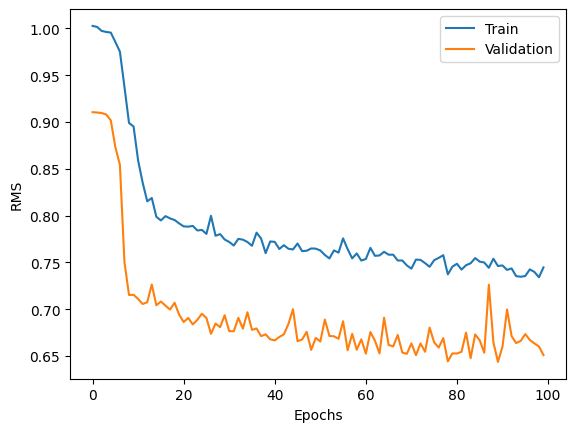

In [ ]:

plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
plt.ylabel('RMS')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Evaluating the performance

O modelo é alternado para o modo de avaliação e algumas estatísticas são calculadas na forma de raiz do erro quadrático médio (RMSE).

In [ ]:
model.eval() #Swith to evaluation mode, where dropout is switched off
#y_pred_train = model(X_train_t)
y_pred_validation = model(X_validation_t)
#y_pred_test = model(X_test)

In [ ]:
torch.mean(( y_validation_t - y_pred_validation )**2).item()

0.6510467529296875

Let’s also vectorize the train and test sets and see how they perform.

In [ ]:
X_train_t = smivec.transform(X_train, canonical=False)
X_train_t = torch.tensor(X_train_t).float()
y_train_t = torch.tensor(y_train).float()
X_test_t = smivec.transform(X_test, canonical=False)
X_test_t = torch.tensor(X_test_t).float()
y_test_t = torch.tensor(y_test).float()

In [ ]:
y_pred_train = model(X_train_t)
y_pred_test = model(X_test_t)
train_rmse = torch.mean(( y_train_t - y_pred_train )**2).item()
test_rmse = torch.mean(( y_test_t - y_pred_test )**2).item()
print("Train RMSE: %0.3F\tTest RMSE: %0.3F"%(train_rmse, test_rmse))

Train RMSE: 0.726	Test RMSE: 0.667


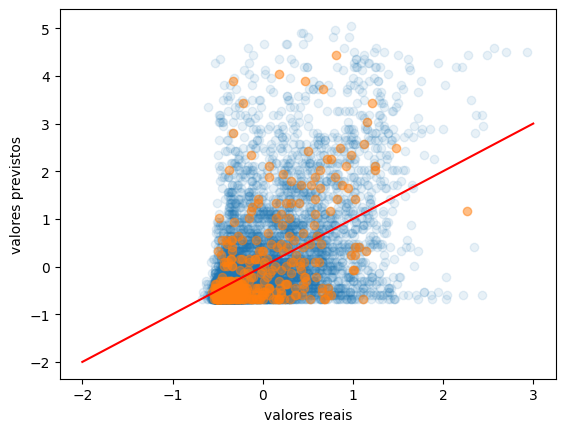

In [ ]:
#A visual plot of the predicted versus real values can also help estimate the goodnes of the fit.

plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1)
plt.scatter(np.array(y_pred_validation.tolist()).flatten(), np.array(y_validation_t.tolist()).flatten(), alpha=0.5)
plt.plot([-2.0, 3.0], [-2.0, 3.0], c="r")
plt.ylabel('valores previstos')
plt.xlabel('valores reais')
plt.show()

In [ ]:
from sklearn.metrics import r2_score


train_r2 = r2_score(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten())
test_r2 = r2_score(np.array(y_pred_validation.tolist()).flatten(), np.array(y_validation_t.tolist()).flatten())

print('Reg linear coef R2 (Treinamento): ', train_r2)
print('Reg linear coef R2 (Validação): ', test_r2)

Reg linear coef R2 (Treinamento):  -1.9518346195820384
Reg linear coef R2 (Validação):  -2.1309341318575394


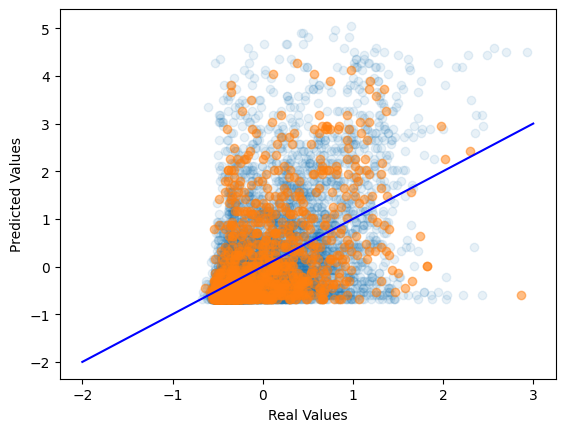

In [ ]:
plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1)
plt.scatter(np.array(y_pred_test.tolist()).flatten(), np.array(y_test_t.tolist()).flatten(), alpha=0.5)
plt.plot([-2.0, 3.0], [-2.0, 3.0], c="b")
plt.ylabel('Predicted Values')
plt.xlabel('Real Values')
plt.show()

In [ ]:
train_r2 = r2_score(np.array(y_pred_train.tolist()).flatten(), np.array(y_train.tolist()).flatten())
test_r2 = r2_score(np.array(y_pred_test.tolist()).flatten(), np.array(y_test.tolist()).flatten())

print('Reg linear coef R2 (Treinamento): ', train_r2)
print('Reg linear coef R2 (Teste): ', test_r2)

Reg linear coef R2 (Treinamento):  -1.9518346208659478
Reg linear coef R2 (Teste):  -1.8813339190041702
